Exercise: *Use policy gradients to solve OpenAI Gym’s LunarLander-v2 environment.*

You should read the [documentation](https://gymnasium.farama.org/environments/box2d/lunar_lander/) about LunarLander-v2.

In [1]:
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2024-04-18 13:50:42.517348: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
env = gym.make("LunarLander-v2", render_mode="rgb_array")

In [3]:
obs, info = env.reset(seed=42)
obs

array([ 0.00229702,  1.4181306 ,  0.2326471 ,  0.3204666 , -0.00265488,
       -0.05269805,  0.        ,  0.        ], dtype=float32)

According to the documentation, the observation is is an 8-dimensional vector, contains, in that order:
- The coordinates of the lander in `x` and `y`.
- Its linear velocities in `x` and `y`.
- Its angle
- Its angular velocity
- Two booleans whether each leg is in contact with the ground or not

In [4]:
info

{}

In [5]:
env.action_space

Discrete(4)

According to the documentation, there are four discrete actions available:
- 0: do nothing
- 1: fire left orientation engine
- 2: fire main engine
- 3: fire right orientation engine

In [6]:
img = env.render()
img.shape

(400, 600, 3)

In [7]:
def plot_environment(env, figsize=(6, 9)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

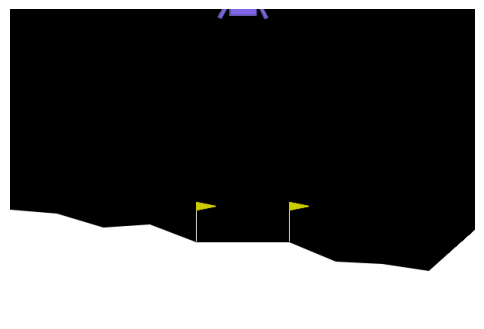

In [8]:
plot_environment(env)
plt.show()

Since now we have 4 possible actions, the model need to be a multiclass classification model. Hence, I'll use a multiclass logistic regression model, using softmax activation function instead of sigmoid.

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

n_inputs = env.observation_space.shape[0]
n_outputs = env.action_space.n

model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(32, activation="relu", input_shape=[n_inputs]),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(n_outputs, activation="softmax"),
    ]
)

2024-04-18 13:50:44.187046: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


We can reuse the `play_one_step()` and `play_multiple_episodes()` functions from the learning notebook, but they need to be tweaked to take into account the fact that `model` is now a multiclass classification model.

Instead of calculating one probability, we need to calculate the probability for each action, and choose an action using these probabilities.

In [10]:
def play_one_lander_step(env, obs, model: tf.keras.Model, loss_fn):
    with tf.GradientTape() as tape:
        proba = model(obs[tf.newaxis])
        logits = tf.math.log(
            proba + tf.keras.backend.epsilon()
        )  # add epsilon to prevent numerical unstable
        action = tf.random.categorical(logits, num_samples=1)
        loss = tf.reduce_mean(loss_fn(action, proba))
    gradients = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(action[0, 0].numpy())
    return obs, reward, done, truncated, gradients

We need to tweak `play_multiple_episodes()` function to use the `play_one_lander_step()` function.

In [11]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_gradients = []
    for episode in range(n_episodes):
        current_rewards = []
        current_gradients = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, gradients = play_one_lander_step(
                env, obs, model, loss_fn
            )
            current_rewards.append(reward)
            current_gradients.append(gradients)
            if done or truncated:
                break
        all_rewards.append(current_rewards)
        all_gradients.append(current_gradients)
    return all_rewards, all_gradients

In [12]:
def discount_rewards(rewards, discount_factor):
    rewards = np.array(rewards)
    for index in range(len(rewards) - 2, -1, -1):
        rewards[index] += rewards[index + 1] * discount_factor
    return rewards


def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [
        discount_rewards(rewards, discount_factor) for rewards in all_rewards
    ]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [
        (discounted_reward - reward_mean) / reward_std
        for discounted_reward in all_discounted_rewards
    ]

Now we need to define some hyperparameters.

In [13]:
n_iterations = 100
n_episodes_per_update = 16
n_max_steps = 1000
discount_factor = 0.99

Since we use a multiclass classification model, and use the the class indices as the the targets, instead of the class probabilities, we need to use the `sparse_categorical_crossentropy()` function.

In [14]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.005)
loss_fn = tf.keras.losses.sparse_categorical_crossentropy

Now we can train the model. For some unknown reasons, this training loop consumes up to nearly 24GB of RAM after 100 iterations, so I will just train it for 50 iterations.

In [15]:
env.reset(seed=42)

mean_rewards = []

for iteration in range(n_iterations):
    all_rewards, all_gradients = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn
    )
    mean_reward = sum(map(sum, all_rewards)) / n_episodes_per_update
    print(
        f"\rIteration: {iteration+1}/{n_iterations}",
        f"mean_rewards: {mean_reward:.2f}",
        end="",
    )
    mean_rewards.append(mean_reward)

    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)
    all_mean_gradients = []
    for var_index in range(len(model.trainable_variables)):
        mean_gradients = tf.reduce_mean(
            [
                final_reward * all_gradients[episode_index][step][var_index]
                for episode_index, final_rewards in enumerate(all_final_rewards)
                for step, final_reward in enumerate(final_rewards)
            ],
            axis=0,
        )
        all_mean_gradients.append(mean_gradients)
    optimizer.apply_gradients(zip(all_mean_gradients, model.trainable_variables))

tf.keras.models.save_model(model, "my_lunar_lander_model")

Iteration: 100/100 mean_rewards: 31.810WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
INFO:tensorflow:Assets written to: my_lunar_lander_model/assets


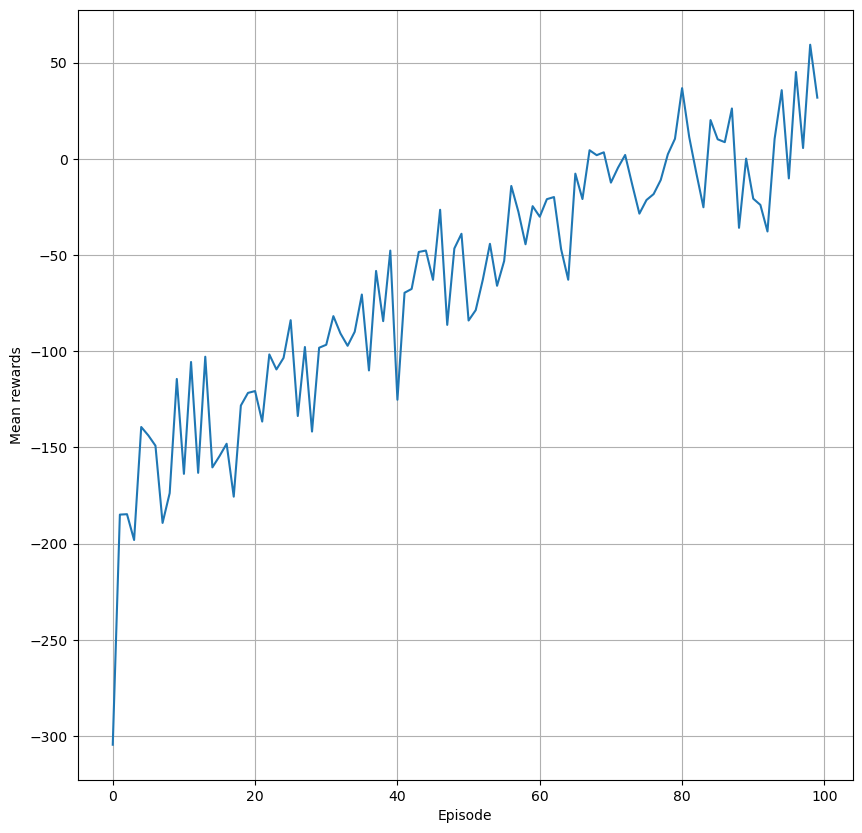

In [16]:
plt.figure(figsize=(10, 10))
plt.plot(mean_rewards)
plt.xlabel("Episode")
plt.ylabel("Mean rewards")
plt.grid()
plt.show()

In [17]:
import matplotlib
import matplotlib.animation

matplotlib.rc("animation", html="jshtml")


def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return (patch,)


def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis("off")
    animation = matplotlib.animation.FuncAnimation(
        fig,
        update_scene,
        fargs=(frames, patch),
        frames=len(frames),
        repeat=repeat,
        interval=interval,
    )
    plt.close()
    return animation


def show_one_lander_episode(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("LunarLander-v2", render_mode="rgb_array")
    tf.random.set_seed(seed)
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        proba = model(obs[tf.newaxis])
        logits = tf.math.log(proba + tf.keras.backend.epsilon())
        action = tf.random.categorical(logits, num_samples=1)
        obs, reward, done, truncated, info = env.step(action[0, 0].numpy())
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)


show_one_lander_episode(model)